C:\Users\szhang\AppData\Local\Temp\ipykernel_34172\370038463.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  employee_counts = data_exploded.groupby(['Week Day', 'Time'])['Shift Count'].sum().reset_index()


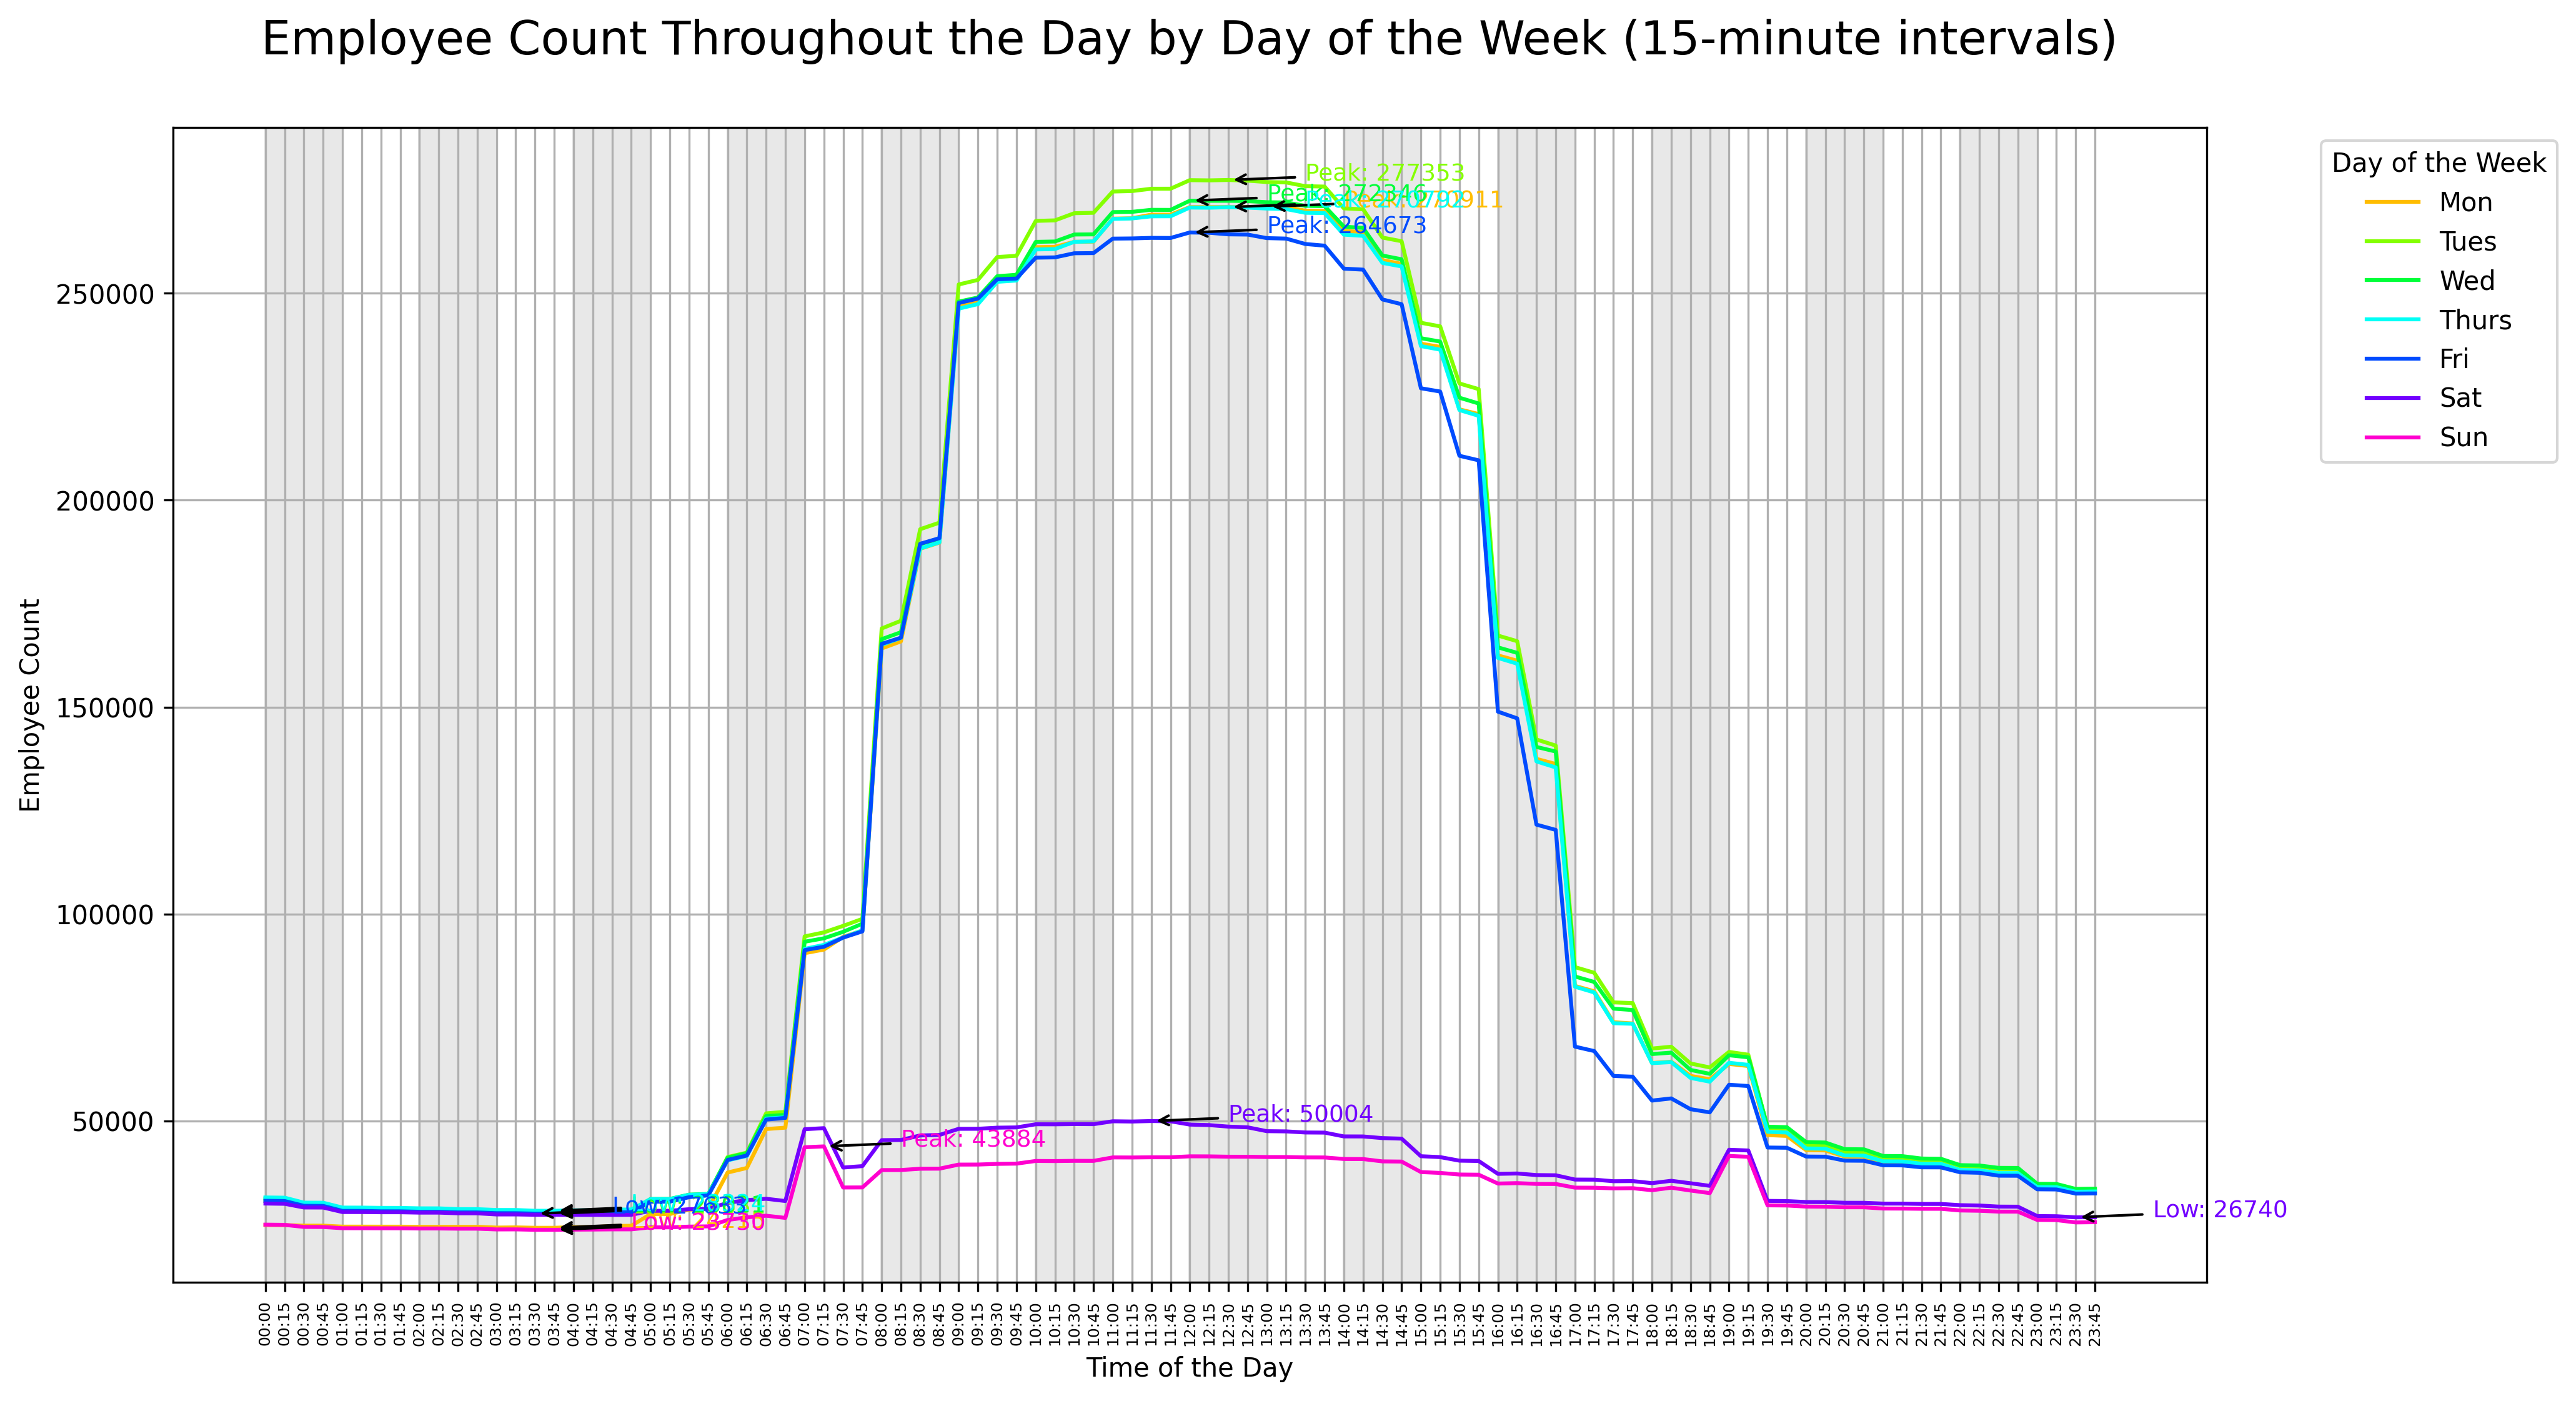

                   Peak    Low
Day of the Week               
Mon              270911  24215
Tues             277353  27631
Wed              272346  28021
Thurs            270792  28324
Fri              264673  27633
Sat               50004  26740
Sun               43884  23730


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the file
file_path = r'C:\\Users\\szhang\\Downloads\\test NYU.csv'
file_path = r"C:\\Users\\szhang\\Downloads\\00001_12876_Dept-Shift-Counts_v1.0_11-13-2019 1_rs.csv"
data = pd.read_csv(file_path, delimiter=',', skipinitialspace=True)

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'LINE'])

# Function to convert time string to minutes since midnight
def time_to_minutes(time_str):
    try:
        hour, minute = map(int, time_str.split(':'))
        return hour * 60 + minute
    except ValueError:
        return None

# Function to create time intervals from shift period, handling overnight shifts
def create_time_intervals(row):
    shift_period = row['Shift Period']
    day = row['Week Day']
    try:
        start_time, end_time = str(shift_period).split('-')
        start_minutes = time_to_minutes(start_time)
        end_minutes = time_to_minutes(end_time)
        intervals = []
        
        if end_minutes <= start_minutes:  # Handle overnight shifts
            # Split the shift at midnight
            current_day_intervals = list(range((start_minutes // 15) * 15, 24 * 60, 15))  # Until midnight
            next_day_intervals = list(range(0, (end_minutes // 15) * 15, 15))  # After midnight
            intervals += current_day_intervals
            intervals += next_day_intervals
            return intervals, current_day_intervals, next_day_intervals  # Intervals before and after midnight
        else:
            intervals = list(range((start_minutes // 15) * 15, (end_minutes // 15) * 15, 15))  # Ensure intervals are on 15-minute marks
            return intervals, intervals, []  # Intervals within the same day
    except ValueError:
        return [], [], []

# Apply the function to create time intervals
data[['Time Intervals', 'Current Day Intervals', 'Next Day Intervals']] = data.apply(create_time_intervals, axis=1, result_type='expand')

# Explode the DataFrame so each interval is a separate row
data_exploded_current = data.explode('Current Day Intervals').dropna(subset=['Current Day Intervals']).rename(columns={'Current Day Intervals': 'Time'})
data_exploded_next = data.explode('Next Day Intervals').dropna(subset=['Next Day Intervals']).rename(columns={'Next Day Intervals': 'Time'})

# Adjust the 'Week Day' for the next day intervals
next_day_map = {
    'Mon': 'Tues',
    'Tues': 'Wed',
    'Wed': 'Thurs',
    'Thurs': 'Fri',
    'Fri': 'Sat',
    'Sat': 'Sun',
    'Sun': 'Mon'
}
data_exploded_next['Week Day'] = data_exploded_next['Week Day'].map(next_day_map)

# Combine current day and next day exploded data
data_exploded = pd.concat([data_exploded_current, data_exploded_next])

# Convert 'Time' to integer type
data_exploded['Time'] = data_exploded['Time'].astype(int)

# Define a custom sorting order for weekdays
weekday_order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
data_exploded['Week Day'] = pd.Categorical(data_exploded['Week Day'], categories=weekday_order, ordered=True)

# Group by 'Week Day' and 'Time' to sum the 'Shift Count'
employee_counts = data_exploded.groupby(['Week Day', 'Time'])['Shift Count'].sum().reset_index()

# Reindex to ensure all 15-minute intervals are included
full_time_index = pd.MultiIndex.from_product([weekday_order, range(0, 24*60, 15)], names=['Week Day', 'Time'])
employee_counts = employee_counts.set_index(['Week Day', 'Time']).reindex(full_time_index, fill_value=0).reset_index()

# Initialize peak and low value storage
peak_values = []
low_values = []

# Plot settings with increased DPI
plt.figure(figsize=(14, 8), dpi=300)
colors = sns.color_palette("hsv", len(weekday_order))

# Alternate background color for every whole hour
for hour in range(0, 24):
    plt.axvspan(hour * 60, (hour + 1) * 60, color='lightgrey' if hour % 2 == 0 else 'white', alpha=0.5)

# add this factor for arrow anootation offset
factor = 1 if max(employee_counts['Shift Count']) < 2000 else 3

# Plot each day with a unique color and annotate peak and low points
for i, day in enumerate(weekday_order):
    day_data = employee_counts[employee_counts['Week Day'] == day]
    if not day_data.empty:
        plt.plot(day_data['Time'], day_data['Shift Count'], label=day, color=colors[i])
        
        # Annotate peak point
        peak_idx = day_data['Shift Count'].idxmax()
        peak = day_data.loc[peak_idx]
        peak_values.append(peak['Shift Count'])
        plt.annotate(f'Peak: {peak["Shift Count"]}', 
                     xy=(peak['Time'], peak['Shift Count']), 
                     xytext=(peak['Time'] + 20*factor, peak['Shift Count'] + 2*factor),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),  # Reduce arrow head size
                     fontsize=9,
                     color=colors[i])
        
        # Annotate low point
        low_idx = day_data['Shift Count'].idxmin()
        low = day_data.loc[low_idx]
        low_values.append(low['Shift Count'])
        plt.annotate(f'Low: {low["Shift Count"]}', 
                     xy=(low['Time'], low['Shift Count']), 
                     xytext=(low['Time'] + 20*factor, low['Shift Count'] - 2*factor),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),  # Reduce arrow head size
                     fontsize=9,
                     color=colors[i])

# Convert time in minutes back to HH:MM format for x-axis labels
time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in range(0, 24*60, 15)]

# Set all time labels and ticks
selected_time_labels = time_labels
selected_time_ticks = range(0, 24*60, 15)

plt.xticks(selected_time_ticks, selected_time_labels, rotation=90, fontsize=6)

# Add titles and labels
plt.title('Employee Count Throughout the Day by Day of the Week (15-minute intervals)', y=1.05, fontsize=18)
plt.xlabel('Time of the Day', y=-1.05)
plt.ylabel('Employee Count')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()

# Create a table with peak and low values
summary_table = pd.DataFrame({
    'Day of the Week': weekday_order,
    'Peak': peak_values,
    'Low': low_values
}).set_index('Day of the Week')

print(summary_table)
